In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [10]:
df = pd.read_csv('./data/train.csv').drop(columns = ['Id'])
df_num = df.select_dtypes(include = ['float64', 'int64'])


In [11]:
df_test = pd.read_csv('./data/test.csv').drop(columns = ['Id'])
df_test['SalePrice'] = pd.read_csv('./data/sample_submission.csv')['SalePrice']


In [12]:
def get_numerical(df : pd.DataFrame, columns : list):
    
    for column in columns:
        id = df[column].unique()
        df[column].replace(id, np.arange(len(id)), inplace = True)
    return df   

In [13]:
df_num = get_numerical(df, list(df.select_dtypes(exclude = ['float64', 'int64']).columns))
df_num_test = get_numerical(df_test, list(df_test.select_dtypes(exclude = ['float64', 'int64']).columns))

WORD EMBEDDINGS

/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

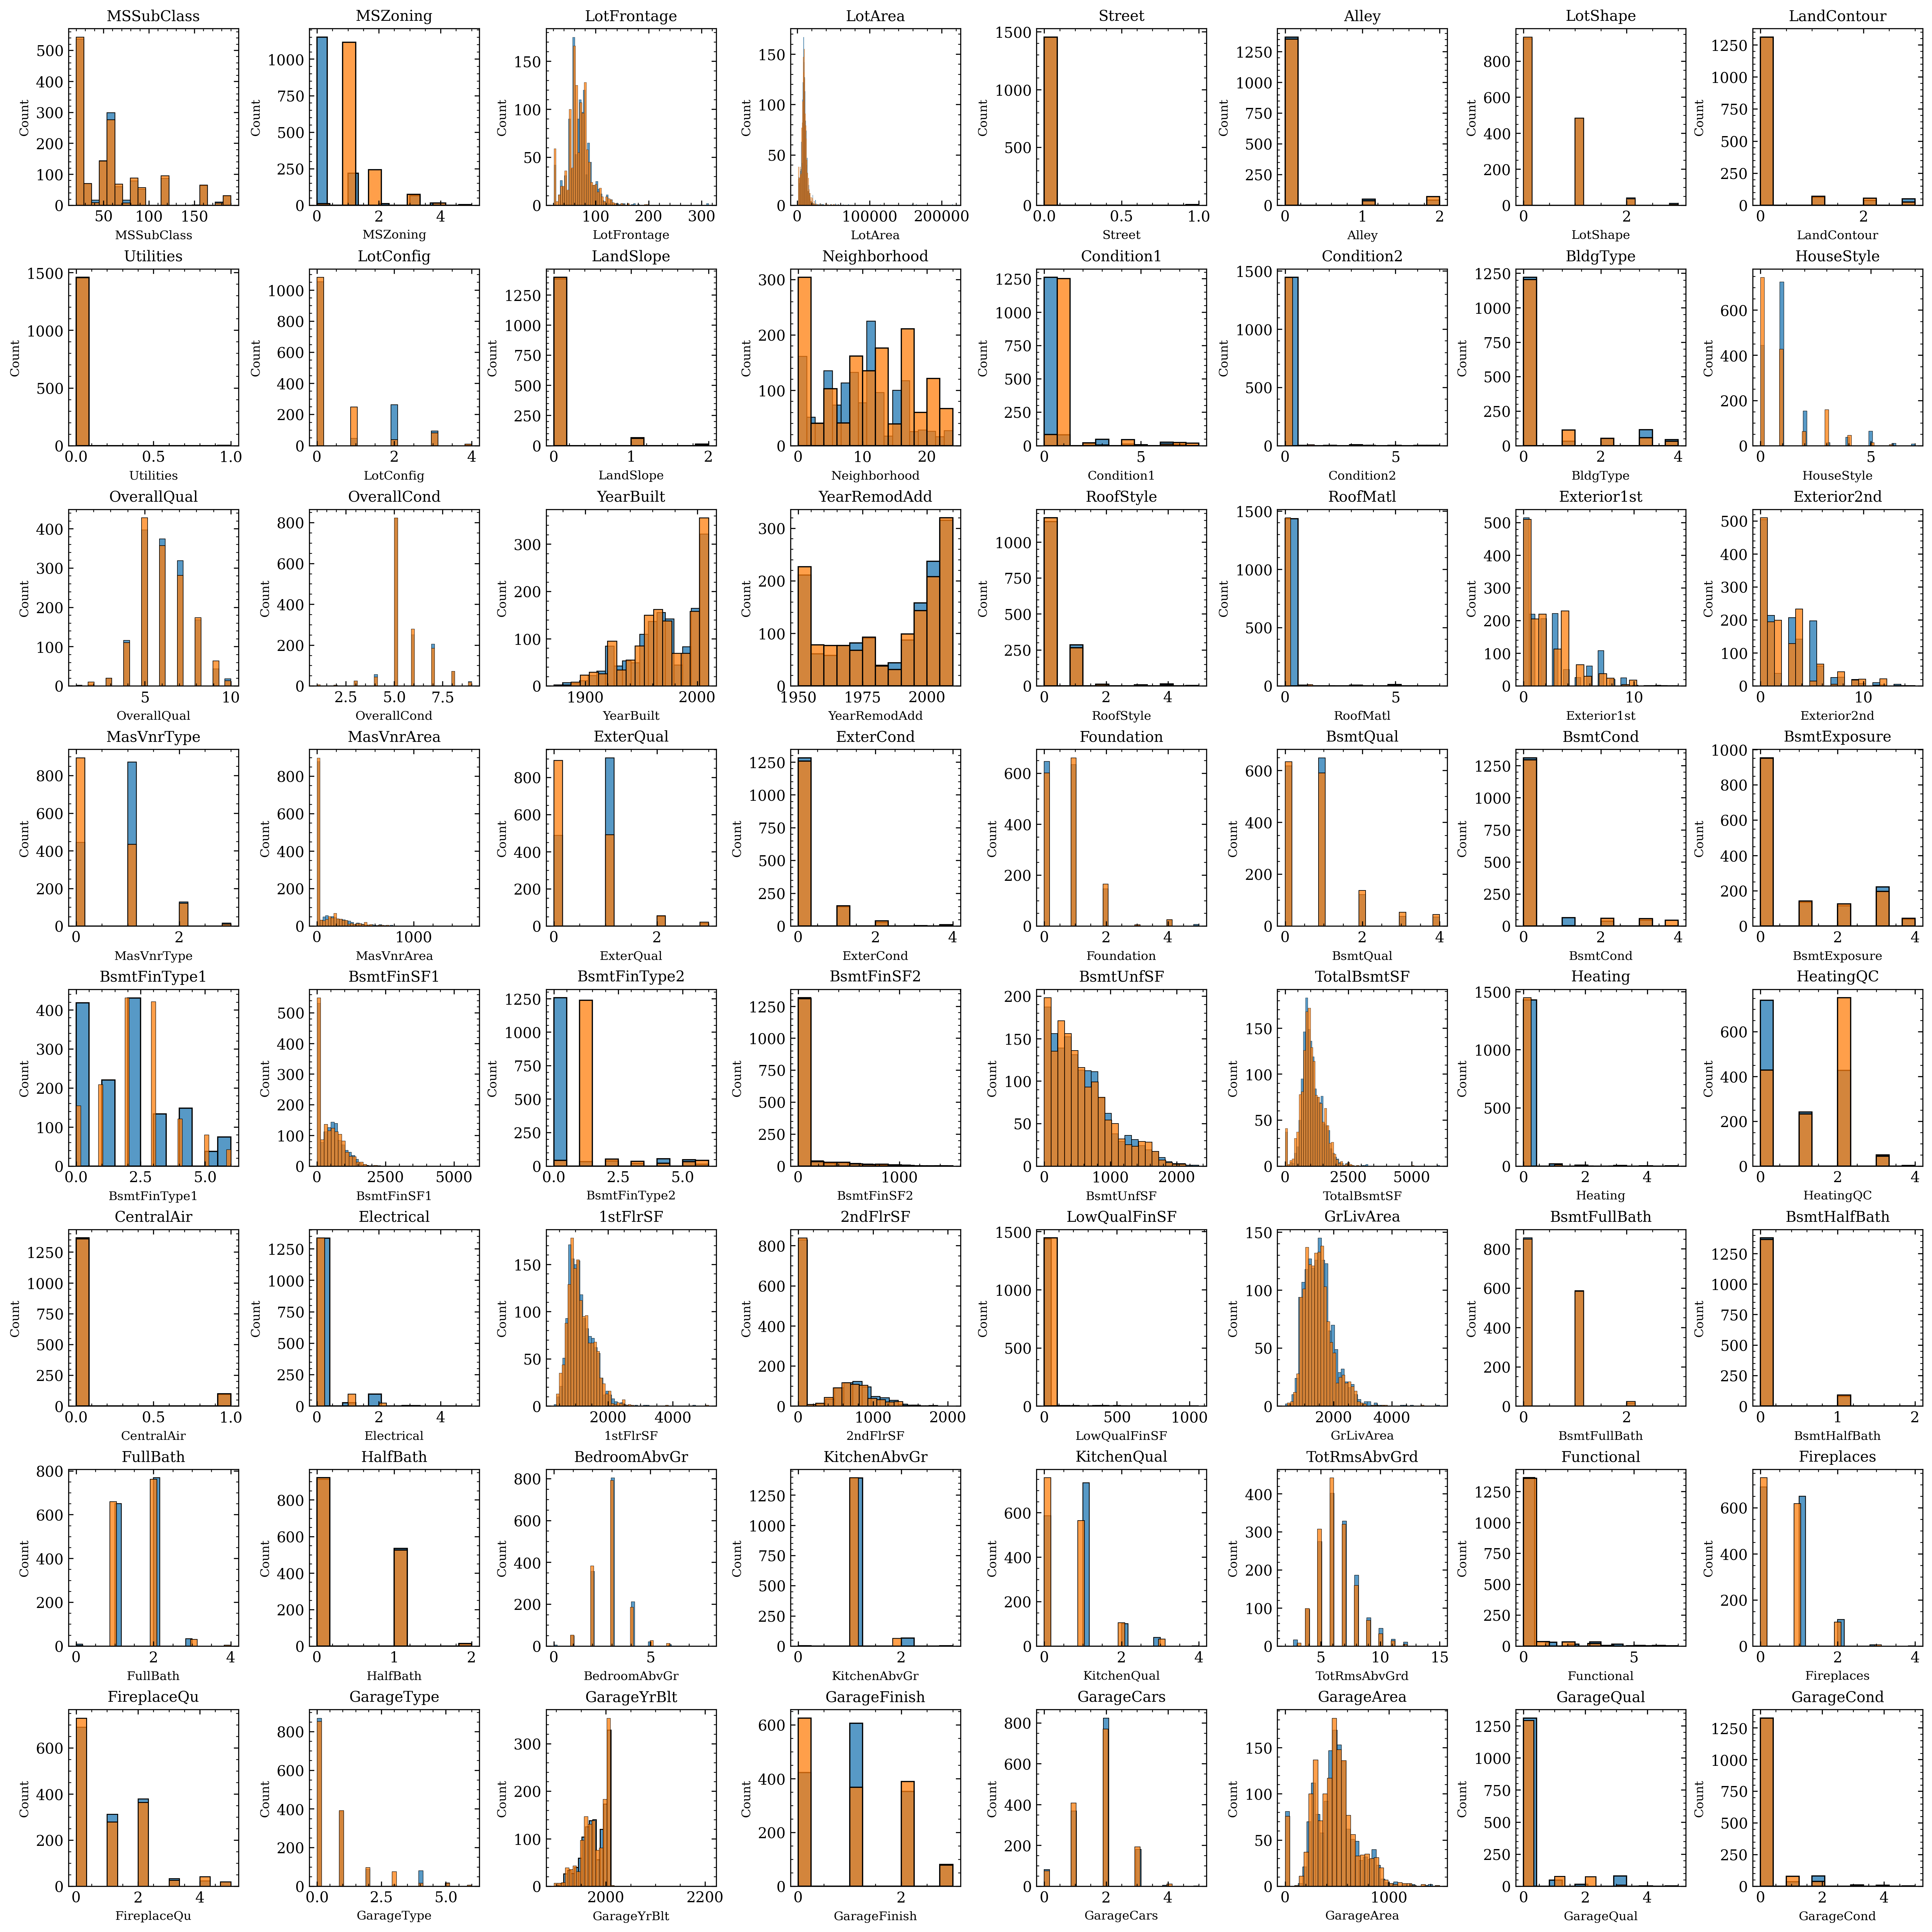

In [14]:
n = int(np.sqrt(len(df_num.columns)))
fig,ax = plt.subplots(n,n,figsize=(20,20))
ax = ax.flatten()
for a,b in zip(df_num_test.columns,ax):
    sns.histplot(df_num[a],ax=b)
    sns.histplot(df_num_test[a],ax=b)
    b.set_title(a)


In [15]:
df_num.corr()['SalePrice'].sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
                  ...   
GarageType     -0.255560
ExterQual      -0.265015
BsmtFinType1   -0.370971
HeatingQC      -0.427649
Foundation     -0.429678
Name: SalePrice, Length: 80, dtype: float64

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split


In [17]:
df_num.fillna(0, inplace=True)
df_num.fillna(0, inplace = True)

df_num_test.fillna(0, inplace=True)
df_num_test.fillna(0, inplace = True)


In [18]:
scaler = RobustScaler()
df_num_scaled = scaler.fit_transform(df_num.drop(columns=['SalePrice']))
df_num_test_scaled = scaler.transform(df_num_test.drop(columns=['SalePrice']))

In [19]:
from sklearn.ensemble import StackingRegressor


estimators = [('rf', RandomForestRegressor(n_estimators=300, max_depth = 20)), ('gb', GradientBoostingRegressor(n_estimators=300, max_depth = 20)), ('ada', AdaBoostRegressor(n_estimators=200))]
clf = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=200, max_depth = 10, criterion='absolute_error'),passthrough = True )

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_num_scaled, df_num['SalePrice'], test_size=0.2, random_state=42)

In [21]:
clf.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=20,
                                                     n_estimators=300)),
                              ('gb',
                               GradientBoostingRegressor(max_depth=20,
                                                         n_estimators=300)),
                              ('ada', AdaBoostRegressor(n_estimators=200))],
                  final_estimator=RandomForestRegressor(criterion='absolute_error',
                                                        max_depth=10,
                                                        n_estimators=200),
                  passthrough=True)

In [22]:
clf.score(X_test, y_test)

0.8934242912733243

In [23]:
clf.score(df_num_test_scaled, df_num_test['SalePrice'])

-16.967360983847716

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  1.,  1.,  0.,  2.,  0.,  1.,  4.,  9.,  7.,
        23., 19., 61., 61., 30., 26., 11., 10., 11.,  6.,  2.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-211517.6825 , -204342.93535, -197168.1882 , -189993.44105,
        -182818.6939 , -175643.94675, -168469.1996 , -161294.45245,
        -154119.7053 , -146944.95815, -139770.211  , -132595.46385,
        -125420.7167 , -118245.96955, -111071.2224 , -103896.47525,
         -96721.7281 ,  -89546.98095,  -82372.2338 ,  -75197.48665,
         -68022.7395 ,  -60847.99235,  -53673.2452 ,  -46498.49805,
         -39323.7509 ,  -32149.00375,  -24974.2566 ,  -17799.50945,
         -10624.7623 ,   -3450.01515,    3724.732  ,   10899.47915,
          18074.2263 ,   25248.97345,   32423.7206 ,   39598.46775,
          46773.2149 ,   53947.96205,   61122.7092 ,   68297.45635,
          75472.2035 ,   82646.95065

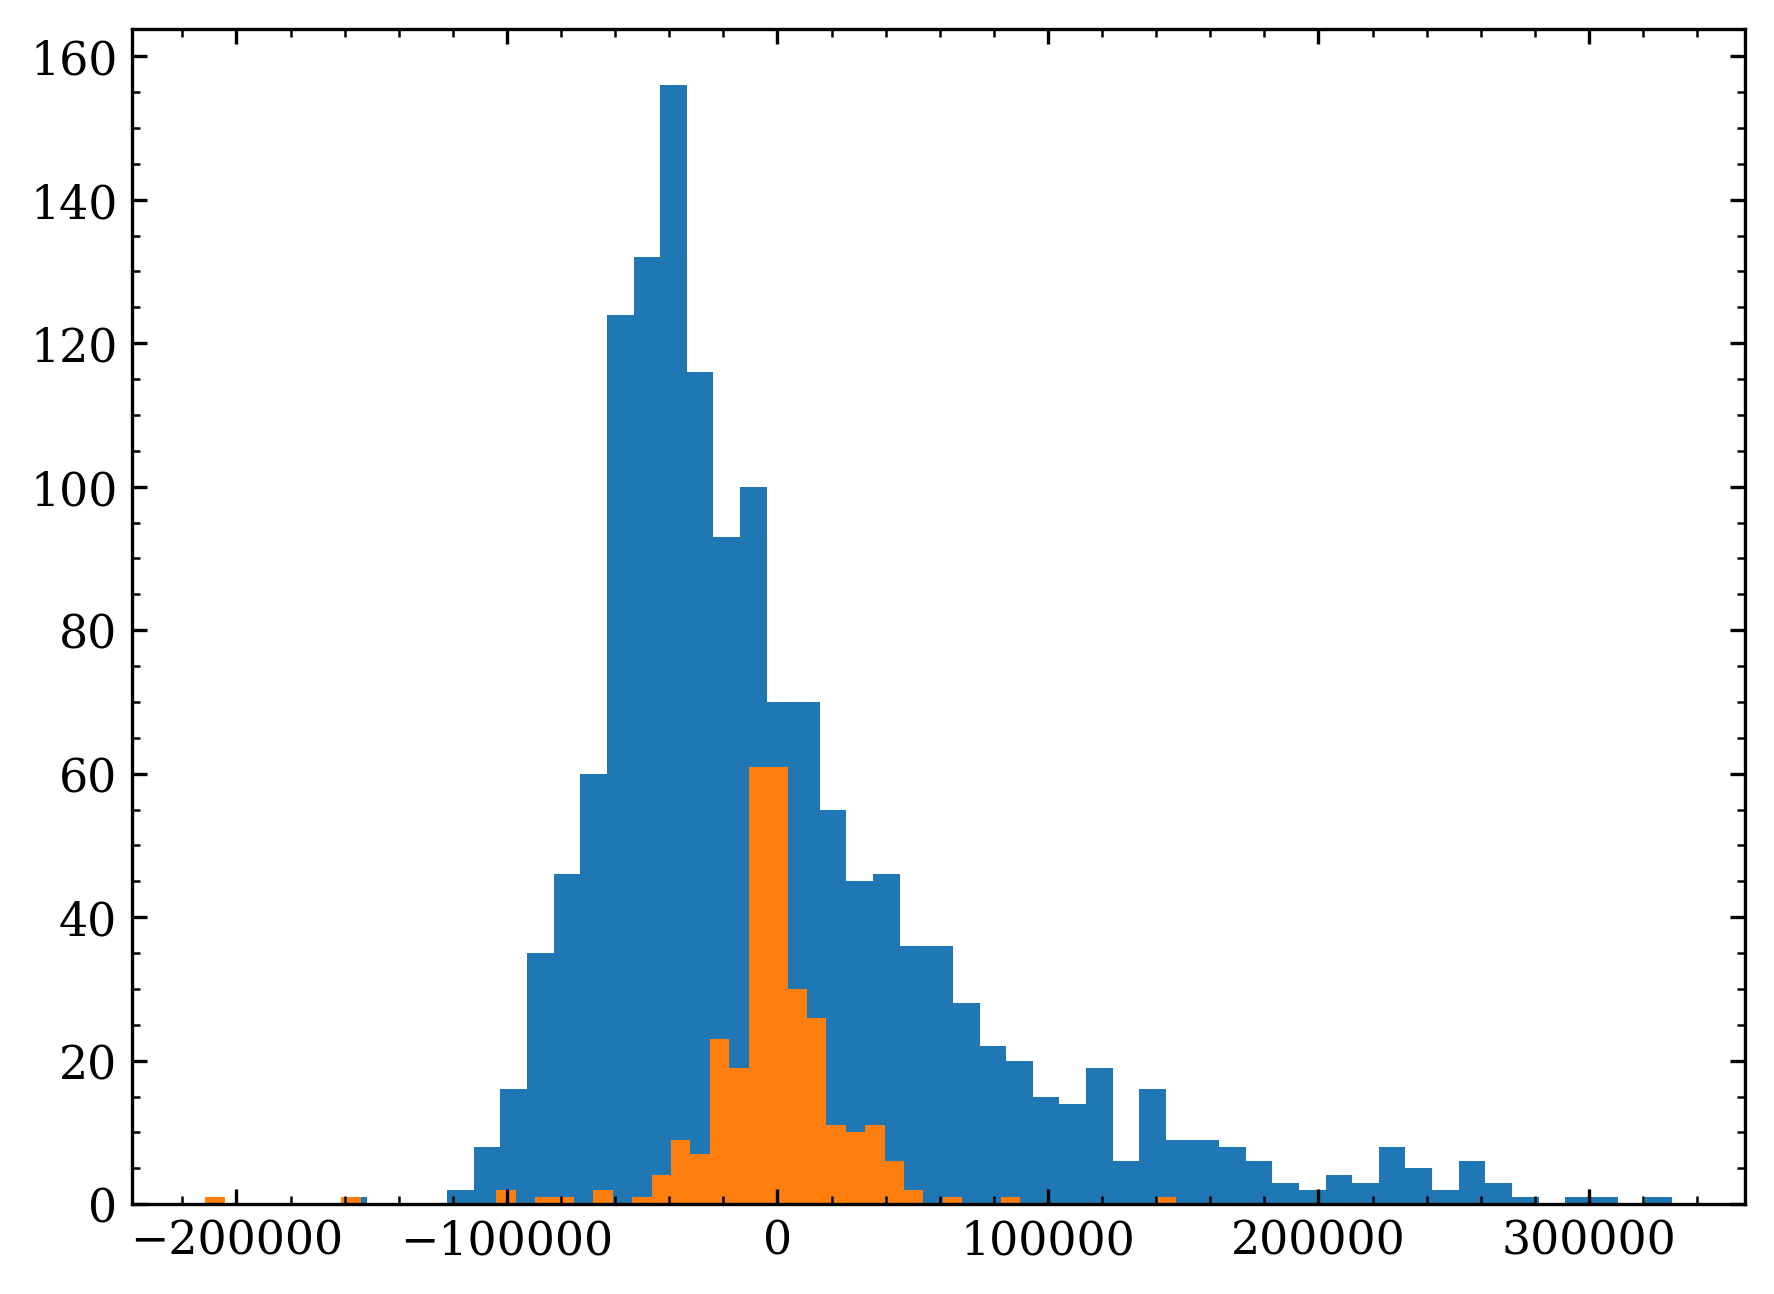

In [24]:
fig, ax = plt.subplots()
ax.hist(clf.predict(df_num_test_scaled) - df_num_test['SalePrice'], bins = 50)
ax.hist(clf.predict(X_test) - y_test, bins = 50)

In [ ]:
y

/tmp/ipykernel_50811/102625270.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


(35311.0, 755000.0)

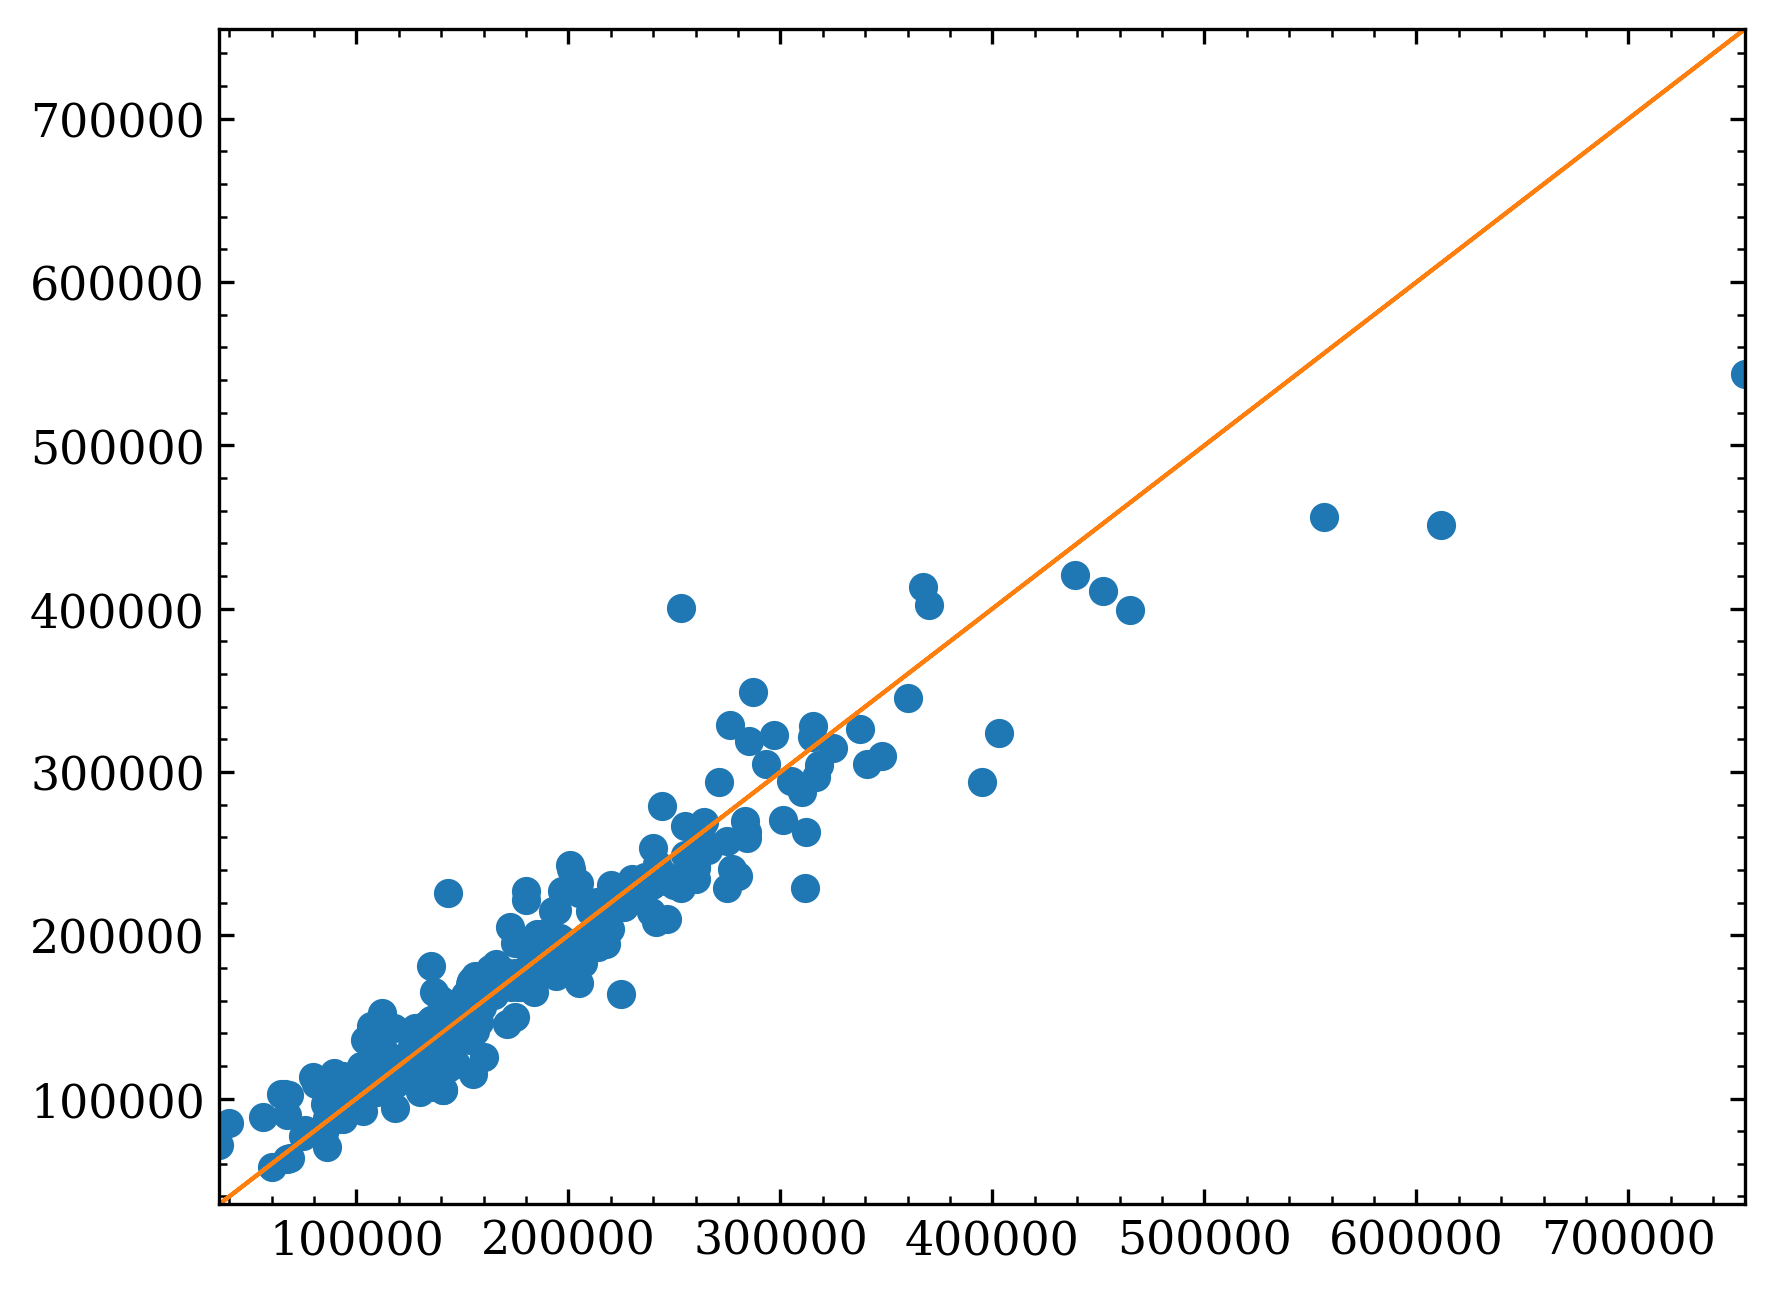

In [25]:
fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')
ax.plot(y_test, clf.predict(X_test), 'o', lw = 0)
ax.plot(y_test, y_test, lw=1)
ax.set_xlim(y_test.min(), y_test.max())
ax.set_ylim(y_test.min(), y_test.max())